# 1 Introduction to Pytorch

This notebook presents an introduction to the PyTorch framework, as part of the material of the first exercise class in the Deep Learning course in the Autumn semester 2023. In the following, a short introduction to PyTorch data structures (tensors) will be made, along with practical examples involving all the components necessary for building, training and testing PyTorch models: starting from the module classes, optimizers, losses, datasets and dataloaders, covering the basics of backpropagation as well. Following the PyTorch introduction, an example of a Perceptron training is presented.

## 1.1 Tensors

Tensors are the main datatype used in the PyTorch framework. Much like numpy arrays, they hold numerical values in arrays of different shapes. Not only that, but in case of mathematical oprations, tensors behave exactly the same as numpy arrays - they even share the same memory space if constructed from one another (when creating an np.array from torch.tensor or vice versa, both object reference the same underlying storage in memory)!

Tensors come with some additional features on top of the numpy arrays - the main feautre being that they contain **gradient information**! 
PyTorch tensors are designed to be used in the context of gradient descent optimization, and therefore they hold not only a tensor with numeric values, but also **the computational graph** leading to these values.

In the following example, we will create some tensors and show how to compute the gradients with respect to any variable needed - this is a crucial part of neural network training.

### Example 1: Tensor gradients

In [1]:
import torch

In [11]:
x = torch.tensor([1., 2., 3.], requires_grad=True) # Input vector
w = torch.tensor([4., 5., 1.], requires_grad=True) # Weight vecotr
t = torch.tensor([2], requires_grad=False) # Target values

y = w @ x # inner-product of x and w
z = (y - t)**2 # square error between the output and target values

z.backward()  # ask pytorch to trace back the computation of z and compute derivatives

print(f"Gradient computed automatically by pytorch: {w.grad}")  # the resulting gradient of z w.r.t w -> computed using backward()
print(f"Gradient computed manually:                 {2*(y-t)*x}")

print(f"Gradient computed automatically by pytorch: {x.grad}")  # the resulting gradient of z w.r.t 
print(f"Gradient computed manually:                 {2*(y-t)*w}")

Gradient computed automatically by pytorch: tensor([30., 60., 90.])
Gradient computed manually:                 tensor([30., 60., 90.], grad_fn=<MulBackward0>)
Gradient computed automatically by pytorch: tensor([120., 150.,  30.])
Gradient computed manually:                 tensor([120., 150.,  30.], grad_fn=<MulBackward0>)


# 1.2 PyTorch models and datasets:

In [122]:
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.datasets import make_regression, make_blobs
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F

%config InlineBackend.figure_format = 'svg'

In [97]:
X, y_true = make_regression(n_samples=60, n_features=10, noise=1.)
X_tensor, y_tensor = torch.tensor(X, dtype=torch.float32), torch.tensor(y_true, dtype=torch.float32)
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor.unsqueeze(1), test_size=0.5)

## 1.2.1 Writing custom datasets:
- A Dataset subclass wraps access to the data, and is specialized to the type of data it’s serving.
- The DataLoader knows nothing about the data, but organizes the input tensors served by the Dataset into batches with the parameters you specify.

torch.utils.data.Dataset is an abstract class representing a dataset. Your custom dataset should inherit Dataset and override the methods \__len\__ and \__getitem\__:

In [222]:
class MyDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, index):
        if self.transform is not None:
            X_t, y_t = self.transform(self.X, self.y)
            return X_t[index], y_t[index]
        else:
            return self.X[index], self.y[index]
    
class MyTransform(object):
    def __init__(self):
        pass
    def __call__(self, X, y):
        return (X-X.mean(axis=0))/X.std(axis=0), (y-y.mean(axis=0))/y.std(axis=0)

# 1.2.2 Training a neural network steps:
**The loss function** is a measure of how far from our ideal output the model’s prediction was. Mean-squared-error loss is a typical loss function for regression models like ours.
**The optimizer** is what drives the learning. Here we use an optimizer that implements stochastic gradient descent. Besides parameters of the algorithm, like the learning rate and momentum, we also pass in net.parameters() - a collection of all the learning weights in the model - which is what the optimizer adjusts.
**Zeroing the gradients** is an important step. Gradients are accumulated over a batch. If we do not reset them for every batch, they will keep accumulating, which will provide incorrect gradient values, making learning impossible.

Usual structure of a training loop:
- Get the outputs of the current batch by passing it through the network
- Compute the loss (Ground truth labels vs the network output)
- Perform a backwards pass of the network (calculates the gradients of loss wrt networks parameters)
- Perform an optimizer step: why this is decoupled from the backwards step is because the optimizer can be abstracted, as it can implement many different algorithms of optimization, all of which require backwards derivatives 

In [103]:
def train(model, train_loader, optimizer, criterion, device):
    epoch_loss = 0

    model.train()
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    return epoch_loss/len(train_loader)

def evaluate(model, val_loader, criterion, device):
    model.eval()

    val_loss = 0
    for x, y in val_loader:
        x, y = x.to(device), y.to(device)
        with torch.no_grad():
            val_loss += criterion(model(x), y).item()

    return val_loss/len(val_loader)

**Note:** The loss function is not independent from the optimizer! It is the final leaf in a single computational graph which starts with the model inputs and contains all model parameters. When we do loss.backward() the process of backpropagation starts at the loss and goes through all of its parents all the way to model inputs. All nodes in the graph contain a reference to their parent.

loss.backward() computes the grad attribute of all tensors with requires_grad=True in the computational graph of which loss is the leaf.

Optimizer just iterates through the list of parameters which have requires_grad=True set, which it received on initialization, and it subtracts the value of its gradient stored in its .grad property, simply multiplied by the learning rate in case of SGD. It doesn't need to know with respect to what loss the gradients were computed it just wants to access that .grad property. The gradients are "stored" by the tensors themselves (they have a grad and a requires_grad attributes) once you call backward() on the loss. After computing the gradients for all tensors in the model, calling optimizer.step() makes the optimizer iterate over all parameters (tensors) it is supposed to update and use their internally stored grad to update their values.

## 1.2.3 Writing custom models:
Some facts and tips about writing a custom PyTorch model:
- It **inherits from torch.nn.Module** - modules may be nested.
- A model should have an **__init__() function**, where it instantiates its layers, and loads any data artifacts it might need (e.g., an NLP model might load a vocabulary).
- A model should have a **forward()** function. This is where the actual computation happens: An input is passed through the network layers and various functions to generate an output.
- Other than that, you can build out your model class like any other Python class, adding whatever properties and methods you need to support your model’s computation.
- PyTorch models assume they are working on batches of data
- Inference is performed by calling it like a function: model(input)
- Output of a model also has a batch dimension, the size of which should always match the input batch dimension.

In [199]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()

        self.input_fc = nn.Linear(input_dim, 10)
        self.hidden_fc = nn.Linear(10, 10)
        self.output_fc = nn.Linear(10, output_dim)

    def forward(self, x):
        h_1 = torch.sigmoid(self.input_fc(x))
        h_2 = torch.sigmoid(self.hidden_fc(h_1))
        y_pred = self.output_fc(h_2)

        return y_pred

epoch 1, loss 12121.63
epoch 2, loss 6314.75
epoch 3, loss 4286.75
epoch 4, loss 2577.46
epoch 5, loss 1710.24
epoch 6, loss 1110.58
epoch 7, loss 718.75
epoch 8, loss 473.69
epoch 9, loss 317.77
epoch 10, loss 220.39
epoch 11, loss 146.96
epoch 12, loss 95.01
epoch 13, loss 66.58
epoch 14, loss 42.05
epoch 15, loss 28.86
epoch 16, loss 19.53
epoch 17, loss 13.09
epoch 18, loss 9.38
epoch 19, loss 7.33
epoch 20, loss 5.52
epoch 21, loss 4.11
epoch 22, loss 3.35
epoch 23, loss 3.01
epoch 24, loss 2.69
epoch 25, loss 2.42
epoch 26, loss 2.33
epoch 27, loss 2.25
epoch 28, loss 2.13
epoch 29, loss 2.15
epoch 30, loss 2.08
epoch 31, loss 2.04
epoch 32, loss 2.01
epoch 33, loss 2.04
epoch 34, loss 2.05
epoch 35, loss 2.03
epoch 36, loss 2.05
epoch 37, loss 2.12
epoch 38, loss 2.14
epoch 39, loss 2.12
epoch 40, loss 2.11


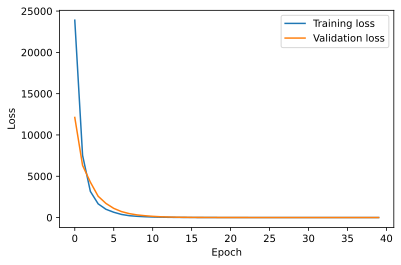

In [203]:
epochs = 40
device = "cuda" if torch.cuda.is_available() else "cpu"

model = torch.nn.Sequential(torch.nn.Linear(10, 1))
# model = MLP(10, 1)
criterion = torch.nn.MSELoss()

trans = None # MyTransform()
train_dataset = MyDataset(X_train, y_train, transform=trans)
val_dataset = MyDataset(X_test, y_test, transform=trans)

train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=10)

optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

model.to(device)
train_loss = []
val_loss = []

for epoch in range(epochs):
    
    epoch_loss_train = train(model, train_loader, optimizer, criterion, device)
    train_loss.append(epoch_loss_train)
    
    epoch_loss_val = evaluate(model, val_loader, criterion, device)
    val_loss.append(epoch_loss_val)

    print(f'epoch {epoch+1}, loss {epoch_loss_val:.2f}')

plt.plot(range(epochs), train_loss, label='Training loss')
plt.plot(range(epochs), val_loss, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

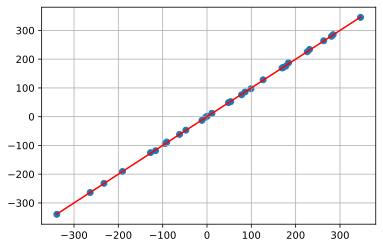

In [204]:
with torch.no_grad():
    pred = model(X_test.cuda()).cpu().numpy()

plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r')
plt.scatter(y_test.numpy(), pred);
plt.grid()

# 2 The perceptron

In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
%config InlineBackend.figure_format = 'svg'

### 2.1 Random dataset with two blobs

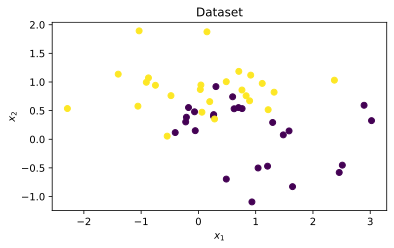

In [9]:
X, y = make_blobs(n_samples=50, centers=2, random_state=4)

X = preprocessing.scale(X)
# X[y==0] += 1 # linearly non-separable data

y[y==0]=-1
plt.scatter(X[:,0], X[:,1], c=y)
plt.title("Dataset")
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.show()

In [214]:
# split train and test data
y_true = y

# add a dimension for bias
X = np.hstack((X, np.ones((X.shape[0], 1))))

X_train, X_test, y_train, y_test = train_test_split(X, y_true, stratify=y)
print(f'Shape X_train: {X_train.shape}')
print(f'Shape y_train: {y_train.shape}')
print(f'Shape X_test: {X_test.shape}')
print(f'Shape y_test: {y_test.shape}')

Shape X_train: (37, 3)
Shape y_train: (37,)
Shape X_test: (13, 3)
Shape y_test: (13,)


### 2.2 Perceptron class + training algorithm

In [215]:
class Perceptron():
    
    def __init__(self, n_samples, n_features, lr=1., n_iters=1000):
        self.lr = lr
        self.n_samples = n_samples
        self.n_features = n_features
        self.n_iters = n_iters
        self.theta_hist = np.zeros((self.n_features, self.n_iters))
        self._trained = False
        self.train_accuracies = []
        self.test_accuracies = []

        
    def train(self, X_train, y_train, X_test, y_test):
        
        theta = np.random.uniform(size=(self.n_features,))
        
        for i in tqdm(range(self.n_iters)):
            idx = i % self.n_samples
            # Notice that np.sign maps 0 to 0 and is therefore incorret for the perceptron.
            y_predict = 2 * np.int32(np.inner(X_train[idx,:], theta)>=0)-1

            if y_predict * y_train[idx] < 0:
                delta_theta = y_train[idx] * X_train[idx,:]
                theta += self.lr * delta_theta
            self.theta_hist[:,i] = theta

            # all_train
            y_train_predict = np.sign(np.inner(X_train, theta))
            self.train_accuracies.append(np.mean(y_train_predict == y_train))

            # test
            y_test_predict = np.sign(np.inner(X_test, theta))
            self.test_accuracies.append(np.mean(y_test_predict == y_test))
        
        self._trained = True
        

    def is_trained(self):
        if not self._trained:
            raise ValueError("Model has not been trained.")

    @property
    def theta(self):
        self.is_trained()
        return self.theta_hist[:, -1]
    
    @property
    def pocket_idx(self):
        self.is_trained()
        return np.argmax(self.train_accuracies)
    
    @property
    def pocket_theta(self):
        self.is_trained()
        return self.theta_hist[:, self.pocket_idx]
        
        
p = Perceptron(*X_train.shape)
theta = p.train(X_train, y_train, X_test, y_test)

# pocket: take the theta with the best training accuracy.
print(f'\ntheta: {p.theta}')
print(f'pocket_theta: {p.pocket_theta}')

100%|██████████| 1000/1000 [00:00<00:00, 53592.43it/s]


theta: [-0.88736844  3.81557419 -0.32465861]
pocket_theta: [-0.88736844  3.81557419 -0.32465861]


### 2.3 Plotting training curves

Train accuracy last: 1.0
Test accuracy last: 1.0
############################################
Train accuracy pocket: 1.0
Test accuracy pocket: 1.0
########## Thetas ##############


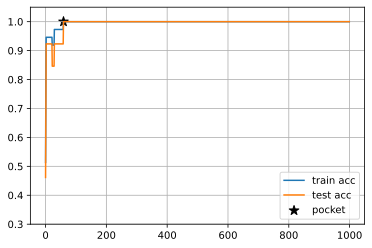

In [216]:
plt.plot(p.train_accuracies, label='train acc')
plt.plot(p.test_accuracies, label='test acc')
plt.scatter(p.pocket_idx, p.train_accuracies[p.pocket_idx], c='k', marker='*', label='pocket', s=100)
plt.ylim([0.3, 1.05])
plt.grid()
plt.legend()

print(f'Train accuracy last: {p.train_accuracies[-1]}')
print(f'Test accuracy last: {p.test_accuracies[-1]}')
print('############################################')
print(f'Train accuracy pocket: {p.train_accuracies[p.pocket_idx]}')
print(f'Test accuracy pocket: {p.test_accuracies[p.pocket_idx]}')
print('########## Thetas ##############')

### 2.4 Visualization of training (parameter space)

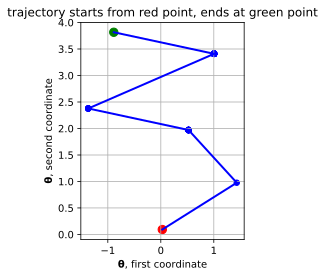

In [217]:
theta_history = p.theta_hist

plt.plot(theta_history[0,:], theta_history[1,:], 'b', lw=2)
plt.scatter(theta_history[0,:], theta_history[1,:], facecolor='b', s=30)
plt.scatter(theta_history[0,0], theta_history[1,0], facecolor='r', s=70)
plt.scatter(theta_history[0,-1], theta_history[1,-1], facecolor='g', s=70)

plt.grid()
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel(r'$\bf \theta$, first coordinate')
plt.ylabel(r'$\bf \theta$, second coordinate')
plt.title('trajectory starts from red point, ends at green point')
plt.savefig('traj.png',dpi = 400)

### 2.5 Visualization of solution

theta: [-0.88736844  3.81557419 -0.32465861]
pocket_theta: [-0.88736844  3.81557419 -0.32465861]


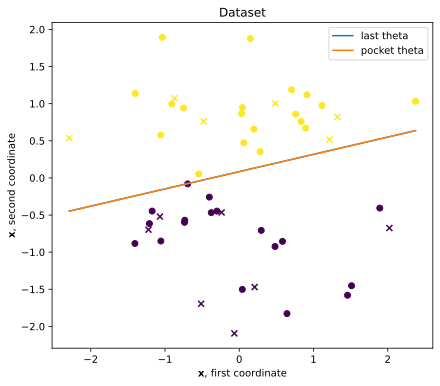

In [218]:
np.max(np.abs(X[:,0]))

fig = plt.figure(figsize=(8,6))
plt.scatter(X_train[:,0], X_train[:,1], c=y_train)
plt.scatter(X_test[:,0], X_test[:,1], c=y_test, marker='x')
x_hyperplane = np.array([np.min(X[:,0]),np.max(X[:,0])])
y_hyperplane = -(x_hyperplane * p.theta[0] + p.theta[2]) / p.theta[1]
plt.plot(x_hyperplane, y_hyperplane, '-', label='last theta')

# pocket solution
y_hyperplane = -(x_hyperplane * p.pocket_theta[0] + p.pocket_theta[2]) / p.pocket_theta[1]
plt.plot(x_hyperplane, y_hyperplane, '-', label='pocket theta')

plt.title("Dataset")
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel(r'$\bf x$, first coordinate')
plt.ylabel(r'$\bf x$, second coordinate')
#plt.ylim([np.min(X[:,1]),np.max(X[:,1])])
print(f'theta: {p.theta}')
print(f'pocket_theta: {p.pocket_theta}')
plt.legend()
plt.show()

### 2.6 Perceptron with Real World Data

In [219]:
from sklearn.datasets import load_digits

X, y = load_digits(n_class=2, return_X_y=True)
y[y==0] = -1.
X_train, X_test, y_train, y_test = train_test_split(X, y)
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [220]:
p = Perceptron(*X_train.shape, n_iters=50)
p.train(X_train, y_train, X_test, y_test)

100%|██████████| 50/50 [00:00<00:00, 20440.08it/s]


Train accuracy last: 0.9962962962962963
Test accuracy last: 0.9888888888888889
############################################
Train accuracy pocket: 0.9962962962962963
Test accuracy pocket: 0.9888888888888889
########## Thetas ##############


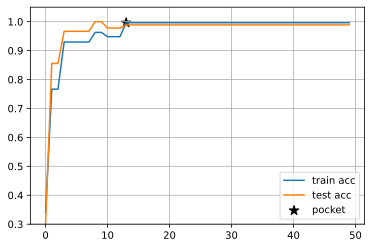

In [221]:
plt.plot(p.train_accuracies, label='train acc')
plt.plot(p.test_accuracies, label='test acc')
plt.scatter(p.pocket_idx, p.train_accuracies[p.pocket_idx], c='k', marker='*', label='pocket', s=100)
plt.ylim([0.3, 1.05])
plt.grid()
plt.legend()

print(f'Train accuracy last: {p.train_accuracies[-1]}')
print(f'Test accuracy last: {p.test_accuracies[-1]}')
print('############################################')
print(f'Train accuracy pocket: {p.train_accuracies[p.pocket_idx]}')
print(f'Test accuracy pocket: {p.test_accuracies[p.pocket_idx]}')
print('########## Thetas ##############')